In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

## Data Loading

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

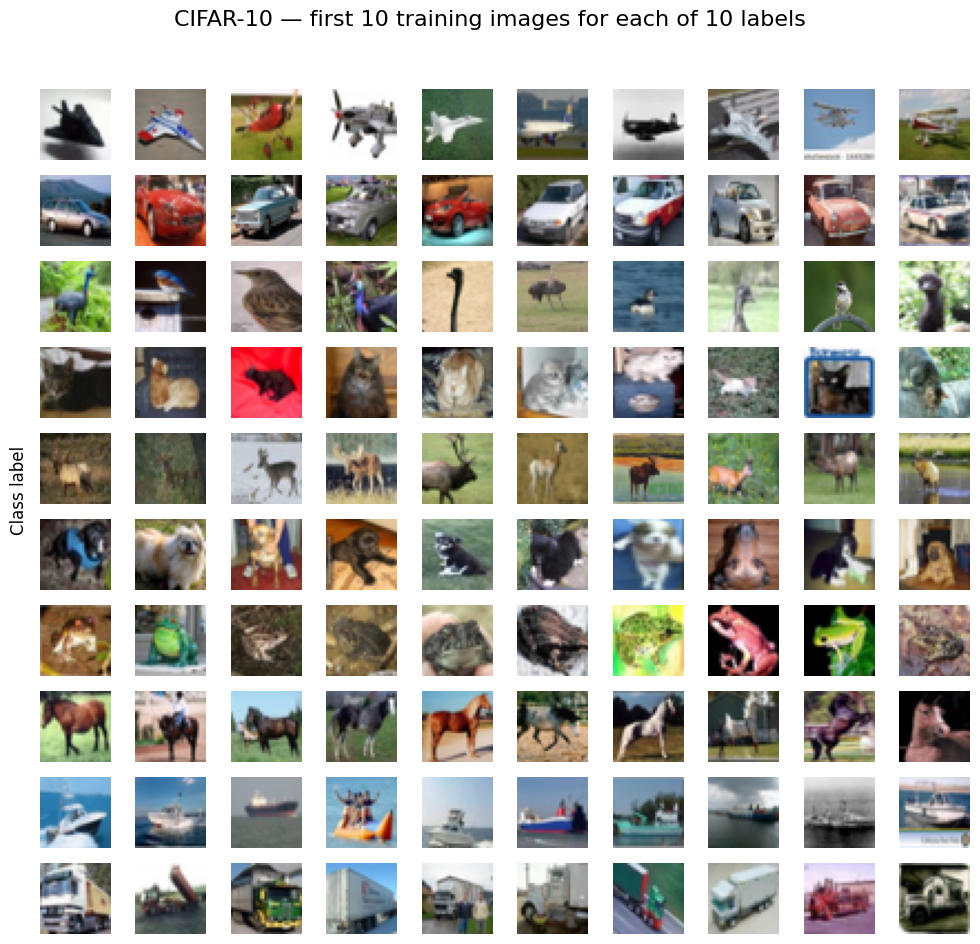

In [18]:
# pick the first 10 distinct labels that appear in x_test
labels_to_plot = np.unique(y_test.ravel())[:10]
if labels_to_plot.size < 10:
    raise RuntimeError("Less than 10 distinct labels found in y_test.")

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), squeeze=False)
for row, label in enumerate(labels_to_plot):
    # find first 10 indices in x_train with this label
    idxs = np.where(y_train.ravel() == label)[0][:10]
    for col in range(10):
        ax = axes[row, col]
        ax.axis("off")
        if col < len(idxs):
            ax.imshow(x_train[idxs[col]])
    # label the row with the class id on the leftmost subplot
    axes[row, 0].set_ylabel(str(int(label)), rotation=0, fontsize=12, labelpad=40, va="center")

# figure title and axis labels
fig.suptitle("CIFAR-10 — first 10 training images for each of 10 labels", fontsize=16)
fig.text(0.02, 0.5, "Class label", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.03, 0.04, 1, 0.95])
plt.show()

## Base Model

Just going to use a basic CNN with a couple of layers, goal is to get >80% accuracy for this initial run

In [ ]:
# build a simple CNN (4 convolutional layers) for CIFAR-10
# uses already-loaded numpy arrays: x_train, y_train, x_test, y_test

# normalize copies of the data (don't overwrite originals)
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm  = x_test.astype("float32")  / 255.0
y_train_flat = y_train.ravel()
y_test_flat  = y_test.ravel()

model = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),

    # Conv block 1 (2 conv layers)
    keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    # Conv block 2 (2 conv layers)
    keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    # classification head
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

# Example: to train (optional)
history = model.fit(x_train_norm, y_train_flat, epochs=10, batch_size=64,
                    validation_data=(x_test_norm, y_test_flat))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,170 (2.26 MB)

 Trainable params: 591,722 (2.26 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.4819 - loss: 1.4791 - val_accuracy: 0.6363 - val_loss: 1.0481
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.6424 - loss: 1.0229 - val_accuracy: 0.6313 - val_loss: 1.1044
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6947 - loss: 0.8830 - val_accuracy: 0.6657 - val_loss: 0.9319
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7225 - loss: 0.8004 - val_accuracy: 0.7195 - val_loss: 0.8120
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7446 - loss: 0.7394 - val_accuracy: 0.7263 - val_loss: 0.8356
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7605 - loss: 0.6979 - val_accuracy: 0.7357 - val_loss: 0.7609
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7767 - loss: 0.6571 - val_accuracy: 0.7670 - val_loss: 0.7291
Epoch 8/10
241/782 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7996 - loss: 0.5899